Esse notebook faz as comparações entre modelos usando GRUs e LSTMs bi e unidirecionais pedidas para o exercício de programação final do curso Processamento Neural de Linguagem Natural em Português I, oferecido pela USP. Baseado na lista 6 do mesmo curso.

Aqui, me propus a fazer um modelo de previsão de review score. Dado o texto de uma review para um produto num site de compras, queremos desenvolver um modelo que seja capaz de prever qual foi a nota dada pelo consumidor ao produto.

In [42]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [43]:
tf.__version__

'2.10.0'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [44]:
!mkdir data

A subdirectory or file data already exists.


In [45]:
!curl https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/4639429ec698d7821fc99a0bc665fa213d9fcd5a/B2W-Reviews01.csv --output data/B2W-Reviews01.csv

In [46]:
b2wCorpus = pd.read_csv("data/B2W-Reviews01.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [47]:
b2wCorpus["review_text"]

0         Estou contente com a compra entrega rápida o ú...
1         Por apenas R$1994.20,eu consegui comprar esse ...
2         SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3         MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4         A entrega foi no prazo, as americanas estão de...
                                ...                        
132368    Vale muito, estou usando no controle do Xbox e...
132369    Prático e barato, super indico o produto para ...
132370    Chegou antes do prazo previsto e corresponde a...
132371    Material fraco, poderia ser melhor. Ficou deve...
132372    Comprei esse produto, quando chegou estava com...
Name: review_text, Length: 132373, dtype: object


## Pré-processamento
Nesse modelo, desejamos prever o valor do rating de uma review (de 1 a 5) dado o seu texto. Por isso, o problema é algo parecido com uma versão contínua de análise de sentimento: estamos fazendo uma regressão com saída de 1 a 5 ao invés de só classificando em "positivo" ou "negativo".

Pré-processamento seleciona as colunas "review_text" e "overall_rating" relevantes para nós, seleciona só as linhas com rating válido (entre 1 e 5), dropa linhas com valor NaN e separa em teste e treino.


In [48]:
data = b2wCorpus[["review_text", "overall_rating"]].copy()
print(data.shape)
data = data[(data["overall_rating"] >= 1) & data["overall_rating"] <= 5]
data.dropna(inplace=True, ignore_index=True)
print(data.shape)
print(data.isnull().sum())
X, y = data["review_text"], data["overall_rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=765)
X.head(), y.head(), X_train.shape, X_test.shape, y_train.shape, y_test.shape, X.shape

(132373, 2)
(129098, 2)
review_text       0
overall_rating    0
dtype: int64


(0    Estou contente com a compra entrega rápida o ú...
 1    Por apenas R$1994.20,eu consegui comprar esse ...
 2    SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
 3    MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
 4    A entrega foi no prazo, as americanas estão de...
 Name: review_text, dtype: object,
 0    4
 1    4
 2    4
 3    4
 4    5
 Name: overall_rating, dtype: int64,
 (96823,),
 (32275,),
 (96823,),
 (32275,),
 (129098,))

## Tokenizando





Definimos uma camada de tokenização, usando a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) do Keras.

In [49]:
max_size = 5000
vectorization_layer = keras.layers.TextVectorization(max_tokens=max_size)
vectorization_layer.adapt(X)

## LSTM&GRU

Definimos os modelos, juntando o tokenizador a uma camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e aí em camadas LSTM, LSTM bidirecional, GRU e GRU bidirecional.

In [50]:
embedding_dim = 64
model_dim = 86

vocabulary_size = len(vectorization_layer.get_vocabulary()) + 1
print(vocabulary_size)

LSTM_uni_model = keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, mask_zero=True),
    keras.layers.LSTM(model_dim),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='linear')
    ])
LSTM_uni_model.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mse'])

LSTM_bi_model = keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(model_dim)),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='linear')
    ])
LSTM_bi_model.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mse'])

GRU_uni_model = keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, mask_zero=True),
    keras.layers.GRU(model_dim),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='linear')
    ])
GRU_uni_model.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mse'])

GRU_bi_model = keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.GRU(model_dim)),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='linear')
    ])
GRU_bi_model.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mse'])

5001


Treinamos os modelos. Hiperparâmetro batch_size foi ajustado algumas vezes, mas decidi usar um número de épocas que fizesse com que os modelos não demorassem muito para treinar.

In [51]:
batch_size = 64
for model in [LSTM_uni_model, LSTM_bi_model, GRU_uni_model, GRU_bi_model]:
    model.fit(X_train.values, y_train.values, epochs=10, batch_size=batch_size, validation_data=(X_test.values, y_test.values))

Epoch 1/10
1513/1513 [==============================] - 55s 35ms/step - loss: 1.1730 - mse: 2.5362 - val_loss: 0.7444 - val_mse: 1.0301
Epoch 2/10
1513/1513 [==============================] - 54s 36ms/step - loss: 0.6963 - mse: 0.9585 - val_loss: 0.6603 - val_mse: 0.9014
Epoch 3/10
1513/1513 [==============================] - 51s 34ms/step - loss: 0.6284 - mse: 0.8329 - val_loss: 0.6220 - val_mse: 0.8448
Epoch 4/10
1513/1513 [==============================] - 53s 35ms/step - loss: 0.5968 - mse: 0.7829 - val_loss: 0.6051 - val_mse: 0.8358
Epoch 5/10
1513/1513 [==============================] - 51s 34ms/step - loss: 0.5749 - mse: 0.7525 - val_loss: 0.5953 - val_mse: 0.8115
Epoch 6/10
1513/1513 [==============================] - 54s 36ms/step - loss: 0.5610 - mse: 0.7300 - val_loss: 0.5889 - val_mse: 0.8271
Epoch 7/10
1513/1513 [==============================] - 55s 36ms/step - loss: 0.5448 - mse: 0.7105 - val_loss: 0.5775 - val_mse: 0.7937
Epoch 8/10
1513/1513 [==========================

Retornamos os resultados dos modelos: os parâmetros finais de acurácia (mean squared e mean absolute error) e um histograma das previsões.

Resultados do modelo LSTM unidirecional:
253/253 [==============================] - 26s 100ms/step - loss: 0.5212 - mse: 0.6948
[0.5212223529815674, 0.6947882771492004]
4035/4035 [==============================] - 25s 6ms/step
        overall_rating  prediction
0                    4    2.773747
1                    4    4.701863
2                    4    4.919489
3                    4    4.767323
4                    5    4.979930
...                ...         ...
129093               5    4.789030
129094               5    4.801334
129095               4    4.430961
129096               1    2.277420
129097               1    1.029680

[129098 rows x 2 columns]


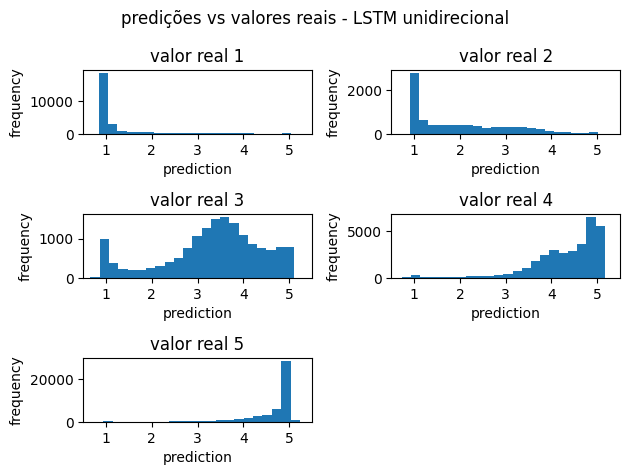

Resultados do modelo LSTM bidirecional:
253/253 [==============================] - 79s 305ms/step - loss: 0.5250 - mse: 0.6572
[0.5249682068824768, 0.6572048664093018]
4035/4035 [==============================] - 72s 18ms/step
        overall_rating  prediction
0                    4    3.107922
1                    4    4.087678
2                    4    4.633101
3                    4    4.501110
4                    5    4.687231
...                ...         ...
129093               5    4.599444
129094               5    4.363297
129095               4    4.348701
129096               1    2.658710
129097               1    0.975816

[129098 rows x 2 columns]


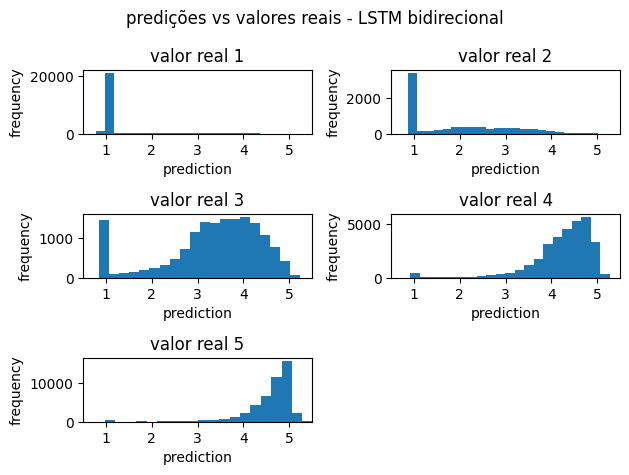

Resultados do modelo GRU unidirecional:
253/253 [==============================] - 34s 130ms/step - loss: 0.5439 - mse: 0.7196
[0.5438856482505798, 0.7196406126022339]
4035/4035 [==============================] - 27s 6ms/step
        overall_rating  prediction
0                    4    2.549189
1                    4    4.054469
2                    4    4.995176
3                    4    4.909586
4                    5    4.585497
...                ...         ...
129093               5    4.080096
129094               5    4.466262
129095               4    4.351332
129096               1    1.358394
129097               1    0.961774

[129098 rows x 2 columns]


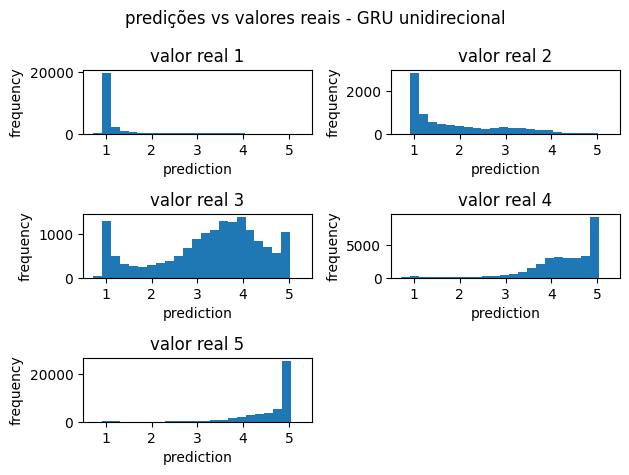

Resultados do modelo GRU bidirecional:
253/253 [==============================] - 114s 444ms/step - loss: 0.5383 - mse: 0.6884
[0.5382986664772034, 0.6883959174156189]
4035/4035 [==============================] - 75s 18ms/step
        overall_rating  prediction
0                    4    2.728520
1                    4    4.203761
2                    4    4.612902
3                    4    4.532659
4                    5    4.730490
...                ...         ...
129093               5    4.314187
129094               5    4.389376
129095               4    4.103883
129096               1    1.883277
129097               1    1.043810

[129098 rows x 2 columns]


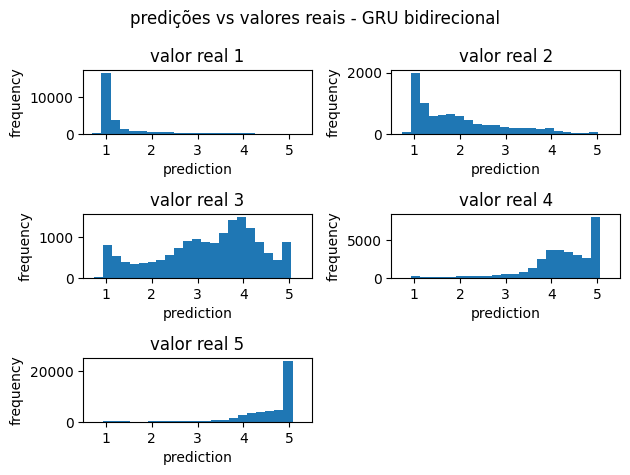

In [52]:

def plot_predictions(overall_rating, prediction, title):
    df = pd.concat([overall_rating, prediction], axis=1)
    print(df)
    groups = [df.loc[df['overall_rating'] == i, 'prediction'] for i in range(1, 6)]
    
    plt.suptitle(f'predições vs valores reais - {title}')
    for i, group in enumerate(groups):
        ax = plt.subplot(3, 2, i+1)
        ax.hist(group, 25)
        ax.set_title(f'valor real {i+1}')
        ax.set_xlim(0.5, 5.5)
        ax.set_xlabel('prediction')
        ax.set_ylabel('frequency')
    plt.tight_layout()
    plt.show()

for model, title in [
    (LSTM_uni_model, "LSTM unidirecional"),
    (LSTM_bi_model, "LSTM bidirecional"),
    (GRU_uni_model, "GRU unidirecional"),
    (GRU_bi_model, "GRU bidirecional")]:
    
    print(f'Resultados do modelo {title}:')
    print(model.evaluate(X, y, batch_size=512))
    plot_predictions(y, pd.Series(model.predict(X).flatten(), name='prediction'), title)


A qualidade dos modelos é OK: os valores extremos (1, 5), que possuem uma grande quantidade de exemplos, são previstos com acurácia boa, mas os valores intermediários (2, 4) só apresentam um desvio ligeiro na direção do 1 e 5 (e não uma distribuição unimodal centrada em (2, 4)), e a distribuição do valor 3 é mal-definida. Isso pode ser explicado pela baixa quantidade relativa de exemplos para valores que não são 1 ou 5, logo talvez seria útil experimentar com técnicas de augmentação dos dados ou mudanças de arquitetura.

Em termos de comparação de performance, os modelos LSTM apresentaram performance melhor que os modelos GRU. Adicionar bidirecionalidade no modelo GRU melhorou a sua performance, mas para o modelo LSTM não parece ter mudado muita coisa. As formas dos histogramas para diferentes tipos de modelo não parece ter mudado muito também: todos apresentam um viés enorme para valores 1 ou 5. Tirando esse viés, contudo, os modelos LSTM parecem ter a forma mais esperada, com um pico menor nos valores apropriados de 2, 3 e 4.